In [1]:
% cd ~/Documents/GitHub/cs231n-adni/new_code

/Users/elissali/Documents/GitHub/cs231n-adni/new_code


In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
import data, model, interpretation, utils, vis_utils

torch.Size([32, 1])


In [4]:
train_data = np.load("train_aug.npy")
val_data = np.load("val_aug.npy")
test_data = np.load("test_aug.npy")
train_label = np.load("train_label_aug.npy")
val_label = np.load("val_label_aug.npy")
test_label = np.load("test_label_aug.npy")

train_data = np.reshape(train_data, (2048, 1, 64, 64, 64))
val_data = np.reshape(val_data, (512, 1, 64, 64, 64))
test_data = np.reshape(test_data, (512, 1, 64, 64, 64))

# Visualisation

In [5]:
train_data[0].shape

(1, 64, 64, 64)

In [6]:
train_data = np.reshape(train_data, (2048, 1, 64, 64, 64))      # want channels first!

In [7]:
train_ex = torch.from_numpy(train_data[0])

In [8]:
train_ex = torch.squeeze(train_ex)

In [9]:
train_ex.shape

torch.Size([64, 64, 64])

tensor(-1.0938, dtype=torch.float64) tensor(2.8692, dtype=torch.float64) None None


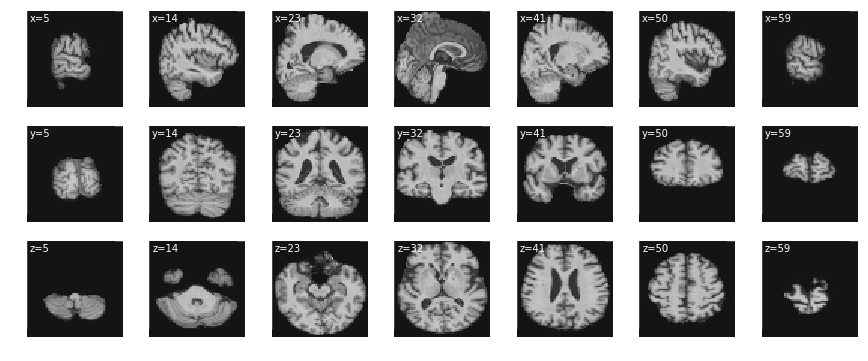

In [10]:
vis_utils.plot_slices(train_ex)

tensor(-1.2525, dtype=torch.float64) tensor(2.4545, dtype=torch.float64) None None


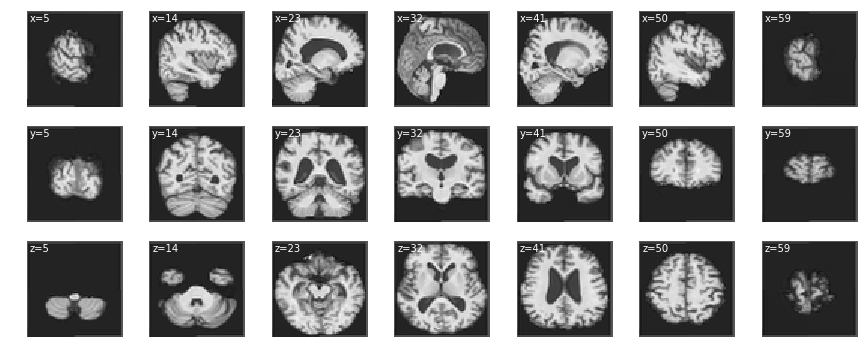

In [11]:
train_ex_2000 = torch.squeeze(torch.from_numpy(train_data[2000]))
vis_utils.plot_slices(train_ex_2000)

In [12]:
net = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

In [13]:
# net.load_state_dict(torch.load('../ckpt/2020_5_5_21_44/model_best.pth.tar')['model'])

In [14]:
net.load_state_dict(torch.load('../ckpt/2020_5_13_1_30/epoch004.pth.tar')['model'])

<All keys matched successfully>

In [15]:
# for item in net.state_dict():
#     print(item)

# for item in torch.load('../ckpt/2020_5_5_21_44/model_best.pth.tar')['model']:
#     print(item)

In [16]:
net.eval();

In [17]:
train_data[2000][0].shape
train_data[0][0].shape

(64, 64, 64)

# Sensitivity Analysis

In [18]:
relevance_map_backprop = interpretation.sensitivity_analysis(net, train_data[0], cuda=False, verbose=True)

output:  tensor([[-4.0040]], grad_fn=<AddmmBackward>)
Image was classified as 0 with probability 0.9820836111903191
one hot output:  tensor([[[1.],
         [0.]]])


tensor(-1.0938, dtype=torch.float64) tensor(2.8692, dtype=torch.float64) 3.3969627e-10 0.002243255654349929


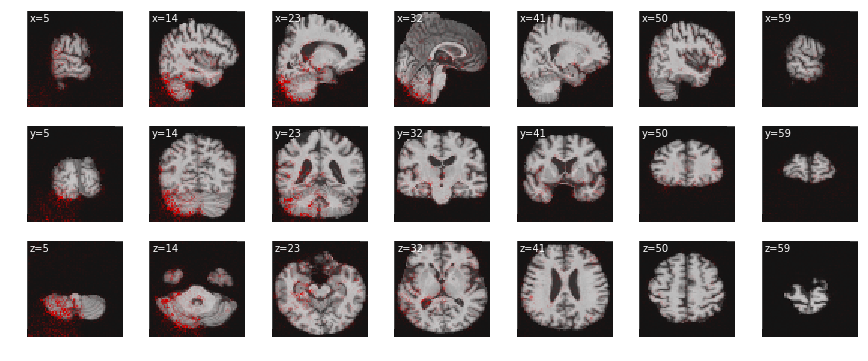

In [19]:
vis_utils.plot_slices(train_ex, num_slices = 7, overlay=relevance_map_backprop[0], 
                  overlay_vmax=np.percentile(relevance_map_backprop, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

In [20]:
relevance_map_backprop = interpretation.sensitivity_analysis(net, train_data[2000], cuda=False, verbose=True)

output:  tensor([[3.1999]], grad_fn=<AddmmBackward>)
Image was classified as 1 with probability 0.9608314037322998
one hot output:  tensor([[[0.],
         [1.]]])


-1.2525044640745717 2.4545196225244514 9.913492e-10 0.00526706877257683


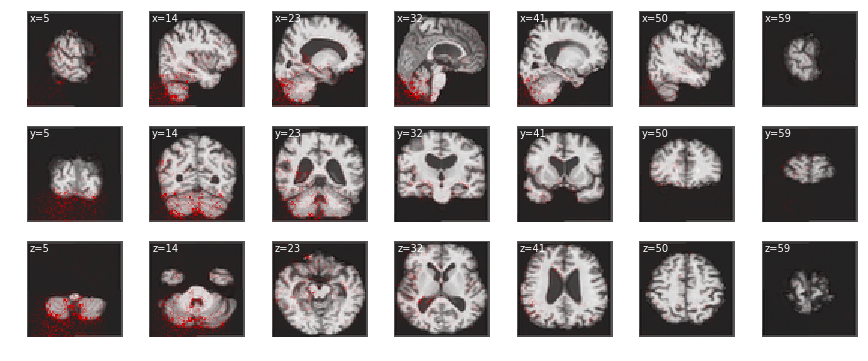

In [21]:
vis_utils.plot_slices(train_data[2000][0], overlay=relevance_map_backprop[0], 
                  overlay_vmax=np.percentile(relevance_map_backprop, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

# Guided Backprop

In [22]:
relevance_map_guided = interpretation.guided_backprop(net, train_data[0], cuda=False, verbose=True)

output:  tensor([[-4.0040]], grad_fn=<AddmmBackward>)
Image was classified as 0 with probability 0.9820836111903191
one hot output:  tensor([[[1.],
         [0.]]])
Removing 0 hook(s)


tensor(-1.0938, dtype=torch.float64) tensor(2.8692, dtype=torch.float64) 3.3969627e-10 0.002243255654349929


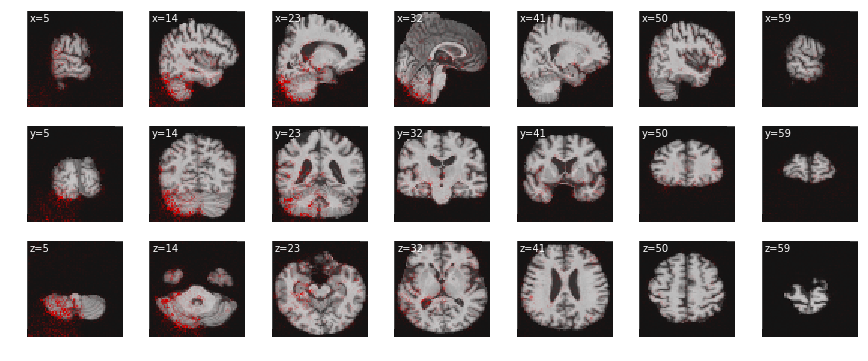

In [23]:
vis_utils.plot_slices(train_ex, overlay=relevance_map_guided[0], 
                  overlay_vmax=np.percentile(relevance_map_guided, 99.9))

In [24]:
relevance_map_guided = interpretation.guided_backprop(net, train_data[2000], cuda=False, verbose=True)

output:  tensor([[3.1999]], grad_fn=<AddmmBackward>)
Image was classified as 1 with probability 0.9608314037322998
one hot output:  tensor([[[0.],
         [1.]]])
Removing 0 hook(s)


-1.2525044640745717 2.4545196225244514 9.913492e-10 0.00526706877257683


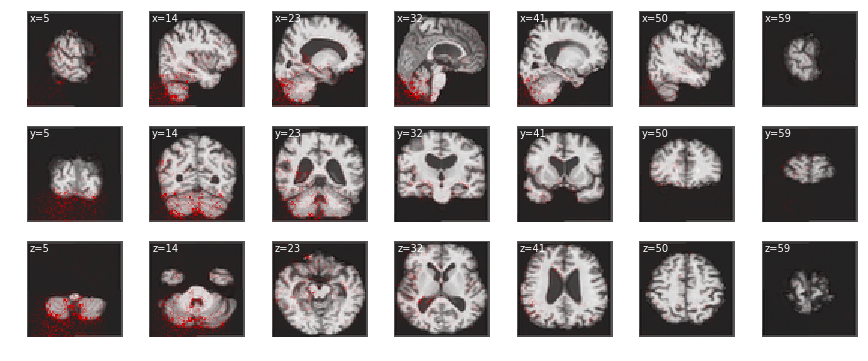

In [26]:
vis_utils.plot_slices(train_data[2000][0], overlay=relevance_map_guided[0], 
                  overlay_vmax=np.percentile(relevance_map_guided, 99.9))

# Occlusion

In [27]:
relevance_map_occlusion = interpretation.occlusion(net, train_data[0], size=10, stride=5, cuda=False, resize=True, verbose=True)

Image was classified as 0 with probability 0.9820836111903191
unoccluded_prob:  0.9820836111903191


output shape:  torch.Size([1, 1])
output:  tensor([[0.0180]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9819697141647339
output shape:  torch.Size([1, 1])
output:  tensor([[0.0174]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9825672041624784
output shape:  torch.Size([1, 1])
output:  tensor([[0.0173]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9826921205967665
output shape:  torch.Size([1, 1])
output:  tensor([[0.0179]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9821009449660778
output shape:  torch.Size([1, 1])
output:  tensor([[0.0169]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9830651488155127
output shape:  torch.Size([1, 1])
output:  tensor([[0.0177]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9823374599218369
output shape:  torch.Size([1, 1])
output:  tensor([[0.0176]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9824216011911631
output shape:  torch.Size([1, 1])
output:  tensor([[0.0181]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9819304179400206
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0181]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9819198101758957
output shape:  torch.Size([1, 1])
output:  tensor([[0.0148]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9851591931656003
output shape:  torch.Size([1, 1])
output:  tensor([[0.0196]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.980374863371253
output shape:  torch.Size([1, 1])
output:  tensor([[0.0241]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9758599922060966
output shape:  torch.Size([1, 1])
output:  tensor([[0.0195]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.980518227443099
output shape:  torch.Size([1, 1])
output:  tensor([[0.0155]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9844537833705544
output shape:  torch.Size([1, 1])
output:  tensor([[0.0145]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9855225207284093
output shape:  torch.Size([1, 1])
output:  tensor([[0.0179]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9820797760039568
output sha

output shape:  torch.Size([1, 1])
output:  tensor([[0.0171]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9829236567020416
output shape:  torch.Size([1, 1])
output:  tensor([[0.0175]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9825485479086637
output shape:  torch.Size([1, 1])
output:  tensor([[0.0182]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9817992467433214
output shape:  torch.Size([1, 1])
output:  tensor([[0.0188]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9811829514801502
output shape:  torch.Size([1, 1])
output:  tensor([[0.0203]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9796863831579685
output shape:  torch.Size([1, 1])
output:  tensor([[0.0198]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9802288506180048
output shape:  torch.Size([1, 1])
output:  tensor([[0.0181]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9819377437233925
output shape:  torch.Size([1, 1])
output:  tensor([[0.0178]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9822002872824669
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0146]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9853800227865577
output shape:  torch.Size([1, 1])
output:  tensor([[0.0177]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9823178164660931
output shape:  torch.Size([1, 1])
output:  tensor([[0.0180]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.981972960755229
output shape:  torch.Size([1, 1])
output:  tensor([[0.0183]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9817274082452059
output shape:  torch.Size([1, 1])
output:  tensor([[0.0190]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9810447171330452
output shape:  torch.Size([1, 1])
output:  tensor([[0.0189]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9811243172734976
output shape:  torch.Size([1, 1])
output:  tensor([[0.0195]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.980528837069869
output shape:  torch.Size([1, 1])
output:  tensor([[0.0224]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9776408411562443
output sha

output shape:  torch.Size([1, 1])
output:  tensor([[0.0194]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9806274864822626
output shape:  torch.Size([1, 1])
output:  tensor([[0.0165]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9835202433168888
output shape:  torch.Size([1, 1])
output:  tensor([[0.0177]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9822812788188457
output shape:  torch.Size([1, 1])
output:  tensor([[0.0186]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9813834689557552
output shape:  torch.Size([1, 1])
output:  tensor([[0.0198]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9801863208413124
output shape:  torch.Size([1, 1])
output:  tensor([[0.0194]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9805914219468832
output shape:  torch.Size([1, 1])
output:  tensor([[0.0254]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9746465813368559
output shape:  torch.Size([1, 1])
output:  tensor([[0.0238]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9761903807520866
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0179]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9820503480732441
output shape:  torch.Size([1, 1])
output:  tensor([[0.0246]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9753670785576105
output shape:  torch.Size([1, 1])
output:  tensor([[0.0296]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9703967403620481
output shape:  torch.Size([1, 1])
output:  tensor([[0.0158]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9841783195734024
output shape:  torch.Size([1, 1])
output:  tensor([[0.0120]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.988043088465929
output shape:  torch.Size([1, 1])
output:  tensor([[0.0130]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9870382295921445
output shape:  torch.Size([1, 1])
output:  tensor([[0.0193]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9806673489511013
output shape:  torch.Size([1, 1])
output:  tensor([[0.0176]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9823986534029245
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.0192]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9807780794799328
output shape:  torch.Size([1, 1])
output:  tensor([[0.0331]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9668545760214329
output shape:  torch.Size([1, 1])
output:  tensor([[0.0260]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9740426726639271
output shape:  torch.Size([1, 1])
output:  tensor([[0.0647]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9352600648999214
output shape:  torch.Size([1, 1])
output:  tensor([[0.0485]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.95145083963871
output shape:  torch.Size([1, 1])
output:  tensor([[0.0312]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9688294809311628
output shape:  torch.Size([1, 1])
output:  tensor([[0.0168]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9832121338695288
output shape:  torch.Size([1, 1])
output:  tensor([[0.0204]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9796402789652348
output sha

output shape:  torch.Size([1, 1])
output:  tensor([[0.0290]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9709507767111063
output shape:  torch.Size([1, 1])
output:  tensor([[0.0347]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9653061665594578
output shape:  torch.Size([1, 1])
output:  tensor([[0.0255]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9744793958961964
output shape:  torch.Size([1, 1])
output:  tensor([[0.0237]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9762888047844172
output shape:  torch.Size([1, 1])
output:  tensor([[0.0208]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9792061820626259
output shape:  torch.Size([1, 1])
output:  tensor([[0.0207]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9793379809707403
output shape:  torch.Size([1, 1])
output:  tensor([[0.0186]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9813882168382406
output shape:  torch.Size([1, 1])
output:  tensor([[0.0186]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9814396854490042
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0220]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9779722355306149
output shape:  torch.Size([1, 1])
output:  tensor([[0.0205]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9794866163283587
output shape:  torch.Size([1, 1])
output:  tensor([[0.0189]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9810718800872564
output shape:  torch.Size([1, 1])
output:  tensor([[0.0194]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9805976022034883
output shape:  torch.Size([1, 1])
output:  tensor([[0.0201]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.97986776009202
output shape:  torch.Size([1, 1])
output:  tensor([[0.0105]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.989510745741427
output shape:  torch.Size([1, 1])
output:  tensor([[0.0093]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.990668429993093
output shape:  torch.Size([1, 1])
output:  tensor([[0.0077]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9923059367574751
output shape

output shape:  torch.Size([1, 1])
output:  tensor([[0.0161]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9839348271489143
output shape:  torch.Size([1, 1])
output:  tensor([[0.0185]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9814752172678709
output shape:  torch.Size([1, 1])
output:  tensor([[0.0176]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.982361875474453
output shape:  torch.Size([1, 1])
output:  tensor([[0.0172]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9827742073684931
output shape:  torch.Size([1, 1])
output:  tensor([[0.0163]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9836637414991856
output shape:  torch.Size([1, 1])
output:  tensor([[0.0709]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9291049391031265
output shape:  torch.Size([1, 1])
output:  tensor([[0.1527]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.847253680229187
output shape:  torch.Size([1, 1])
output:  tensor([[0.1209]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.8791180178523064
output sha

output shape:  torch.Size([1, 1])
output:  tensor([[0.0433]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9566708318889141
output shape:  torch.Size([1, 1])
output:  tensor([[0.0423]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9576693177223206
output shape:  torch.Size([1, 1])
output:  tensor([[0.0106]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9893890637904406
output shape:  torch.Size([1, 1])
output:  tensor([[0.0105]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9894834896549582
output shape:  torch.Size([1, 1])
output:  tensor([[0.0191]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9809386450797319
output shape:  torch.Size([1, 1])
output:  tensor([[0.0179]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9820766039192677
output shape:  torch.Size([1, 1])
output:  tensor([[0.0173]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9826975781470537
output shape:  torch.Size([1, 1])
output:  tensor([[0.0181]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9818510357290506
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0130]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9869547924026847
output shape:  torch.Size([1, 1])
output:  tensor([[0.0175]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9825364351272583
output shape:  torch.Size([1, 1])
output:  tensor([[0.0373]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9627379402518272
output shape:  torch.Size([1, 1])
output:  tensor([[0.0169]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9831246789544821
output shape:  torch.Size([1, 1])
output:  tensor([[0.0165]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9834556244313717
output shape:  torch.Size([1, 1])
output:  tensor([[0.0159]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9840849172323942
output shape:  torch.Size([1, 1])
output:  tensor([[0.0165]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9834947884082794
output shape:  torch.Size([1, 1])
output:  tensor([[0.0165]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9835266880691051
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0198]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9801532179117203
output shape:  torch.Size([1, 1])
output:  tensor([[0.0212]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9787600245326757
output shape:  torch.Size([1, 1])
output:  tensor([[0.0198]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9801811557263136
output shape:  torch.Size([1, 1])
output:  tensor([[0.0194]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.980555783957243
output shape:  torch.Size([1, 1])
output:  tensor([[0.0191]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9809380564838648
output shape:  torch.Size([1, 1])
output:  tensor([[0.0182]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9817658104002476
output shape:  torch.Size([1, 1])
output:  tensor([[0.0211]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9788609202951193
output shape:  torch.Size([1, 1])
output:  tensor([[0.0217]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9783138129860163
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.0175]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9825420957058668
output shape:  torch.Size([1, 1])
output:  tensor([[0.0187]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9813240971416235
output shape:  torch.Size([1, 1])
output:  tensor([[0.0213]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9786992911249399
output shape:  torch.Size([1, 1])
output:  tensor([[0.0131]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9868865497410297
output shape:  torch.Size([1, 1])
output:  tensor([[0.0124]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9876448353752494
output shape:  torch.Size([1, 1])
output:  tensor([[0.0080]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9920497322455049
output shape:  torch.Size([1, 1])
output:  tensor([[0.0172]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9828108660876751
output shape:  torch.Size([1, 1])
output:  tensor([[0.0135]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.986455095000565
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.0192]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9807785097509623
output shape:  torch.Size([1, 1])
output:  tensor([[0.0235]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9764794986695051
output shape:  torch.Size([1, 1])
output:  tensor([[0.0251]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9749443866312504
output shape:  torch.Size([1, 1])
output:  tensor([[0.0310]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9689518716186285
output shape:  torch.Size([1, 1])
output:  tensor([[0.0280]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9720013439655304
output shape:  torch.Size([1, 1])
output:  tensor([[0.0291]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9708667229861021
output shape:  torch.Size([1, 1])
output:  tensor([[0.0253]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9746954701840878
output shape:  torch.Size([1, 1])
output:  tensor([[0.0244]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9756160881370306
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0100]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9900125600397587
output shape:  torch.Size([1, 1])
output:  tensor([[0.0123]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9877333594486117
output shape:  torch.Size([1, 1])
output:  tensor([[0.0168]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9832358937710524
output shape:  torch.Size([1, 1])
output:  tensor([[0.0159]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9840906150639057
output shape:  torch.Size([1, 1])
output:  tensor([[0.0170]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.982995243743062
output shape:  torch.Size([1, 1])
output:  tensor([[0.0176]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.982367005199194
output shape:  torch.Size([1, 1])
output:  tensor([[0.0174]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.982596168294549
output shape:  torch.Size([1, 1])
output:  tensor([[0.0185]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9814647510647774
output shap

output shape:  torch.Size([1, 1])
output:  tensor([[0.0195]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9805078003555536
output shape:  torch.Size([1, 1])
output:  tensor([[0.0176]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9823754690587521
output shape:  torch.Size([1, 1])
output:  tensor([[0.0143]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9856658056378365
output shape:  torch.Size([1, 1])
output:  tensor([[0.0163]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9837038908153772
output shape:  torch.Size([1, 1])
output:  tensor([[0.0185]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9815225582569838
output shape:  torch.Size([1, 1])
output:  tensor([[0.0176]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9824430234730244
output shape:  torch.Size([1, 1])
output:  tensor([[0.0170]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9829859249293804
output shape:  torch.Size([1, 1])
output:  tensor([[0.0166]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9833975750952959
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0188]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9811816439032555
output shape:  torch.Size([1, 1])
output:  tensor([[0.0189]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9810602776706219
output shape:  torch.Size([1, 1])
output:  tensor([[0.0177]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9822631943970919
output shape:  torch.Size([1, 1])
output:  tensor([[0.0182]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9817581940442324
output shape:  torch.Size([1, 1])
output:  tensor([[0.0201]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9799014497548342
output shape:  torch.Size([1, 1])
output:  tensor([[0.0226]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9773990996181965
output shape:  torch.Size([1, 1])
output:  tensor([[0.0272]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9728459846228361
output shape:  torch.Size([1, 1])
output:  tensor([[0.0326]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9674090817570686
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0199]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9801358692348003
output shape:  torch.Size([1, 1])
output:  tensor([[0.0136]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9863934889435768
output shape:  torch.Size([1, 1])
output:  tensor([[0.0125]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9874501693993807
output shape:  torch.Size([1, 1])
output:  tensor([[0.0091]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.990945428609848
output shape:  torch.Size([1, 1])
output:  tensor([[0.0103]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9896671874448657
output shape:  torch.Size([1, 1])
output:  tensor([[0.0135]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9864806840196252
output shape:  torch.Size([1, 1])
output:  tensor([[0.0157]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.984341798350215
output shape:  torch.Size([1, 1])
output:  tensor([[0.0182]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9817657973617315
output sha

output shape:  torch.Size([1, 1])
output:  tensor([[0.0235]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.976480333134532
output shape:  torch.Size([1, 1])
output:  tensor([[0.0311]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9688748698681593
output shape:  torch.Size([1, 1])
output:  tensor([[0.0262]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9737535417079926
output shape:  torch.Size([1, 1])
output:  tensor([[0.0125]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9875196358188987
output shape:  torch.Size([1, 1])
output:  tensor([[0.0167]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9833098892122507
output shape:  torch.Size([1, 1])
output:  tensor([[0.0210]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9789933580905199
output shape:  torch.Size([1, 1])
output:  tensor([[0.0209]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9791037831455469
output shape:  torch.Size([1, 1])
output:  tensor([[0.0195]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9805228281766176
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.0178]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9821847509592772
output shape:  torch.Size([1, 1])
output:  tensor([[0.0174]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9825997408479452
output shape:  torch.Size([1, 1])
output:  tensor([[0.0174]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9825556930154562
output shape:  torch.Size([1, 1])
output:  tensor([[0.0181]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9818765856325626
output shape:  torch.Size([1, 1])
output:  tensor([[0.0190]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9810306131839752
output shape:  torch.Size([1, 1])
output:  tensor([[0.0184]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9815687946975231
output shape:  torch.Size([1, 1])
output:  tensor([[0.0176]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9823691844940186
output shape:  torch.Size([1, 1])
output:  tensor([[0.0188]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9812211152166128
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0160]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9840251598507166
output shape:  torch.Size([1, 1])
output:  tensor([[0.0132]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9867700776085258
output shape:  torch.Size([1, 1])
output:  tensor([[0.0144]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9856311893090606
output shape:  torch.Size([1, 1])
output:  tensor([[0.0176]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9823877178132534
output shape:  torch.Size([1, 1])
output:  tensor([[0.0191]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9809453673660755
output shape:  torch.Size([1, 1])
output:  tensor([[0.0182]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9817866366356611
output shape:  torch.Size([1, 1])
output:  tensor([[0.0190]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9810018539428711
output shape:  torch.Size([1, 1])
output:  tensor([[0.0182]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9818039797246456
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0181]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9819106571376324
output shape:  torch.Size([1, 1])
output:  tensor([[0.0194]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9806129410862923
output shape:  torch.Size([1, 1])
output:  tensor([[0.0189]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9811256695538759
output shape:  torch.Size([1, 1])
output:  tensor([[0.0194]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9806476756930351
output shape:  torch.Size([1, 1])
output:  tensor([[0.0240]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9759605024009943
output shape:  torch.Size([1, 1])
output:  tensor([[0.0248]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9751904159784317
output shape:  torch.Size([1, 1])
output:  tensor([[0.0307]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9692753870040178
output shape:  torch.Size([1, 1])
output:  tensor([[0.0297]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9702684264630079
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0163]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9836555328220129
output shape:  torch.Size([1, 1])
output:  tensor([[0.0145]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9855101611465216
output shape:  torch.Size([1, 1])
output:  tensor([[0.0131]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9868804635480046
output shape:  torch.Size([1, 1])
output:  tensor([[0.0139]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9861313896253705
output shape:  torch.Size([1, 1])
output:  tensor([[0.0200]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9799861926585436
output shape:  torch.Size([1, 1])
output:  tensor([[0.0184]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9815973918884993
output shape:  torch.Size([1, 1])
output:  tensor([[0.0187]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.981263155117631
output shape:  torch.Size([1, 1])
output:  tensor([[0.0272]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9728345479816198
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.0304]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9696178287267685
output shape:  torch.Size([1, 1])
output:  tensor([[0.0330]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9669964946806431
output shape:  torch.Size([1, 1])
output:  tensor([[0.0269]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9730741139501333
output shape:  torch.Size([1, 1])
output:  tensor([[0.0269]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9731081183999777
output shape:  torch.Size([1, 1])
output:  tensor([[0.0188]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9811588115990162
output shape:  torch.Size([1, 1])
output:  tensor([[0.0179]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9821291882544756
output shape:  torch.Size([1, 1])
output:  tensor([[0.0190]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9810111876577139
output shape:  torch.Size([1, 1])
output:  tensor([[0.0185]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9814992472529411
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0181]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9819018077105284
output shape:  torch.Size([1, 1])
output:  tensor([[0.0187]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9812785256654024
output shape:  torch.Size([1, 1])
output:  tensor([[0.0189]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9811198748648167
output shape:  torch.Size([1, 1])
output:  tensor([[0.0179]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9821421392261982
output shape:  torch.Size([1, 1])
output:  tensor([[0.0173]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9826816059648991
output shape:  torch.Size([1, 1])
output:  tensor([[0.0182]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9817648213356733
output shape:  torch.Size([1, 1])
output:  tensor([[0.0180]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9819693900644779
output shape:  torch.Size([1, 1])
output:  tensor([[0.0210]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9790427889674902
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0177]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9822611659765244
output shape:  torch.Size([1, 1])
output:  tensor([[0.0185]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9815331380814314
output shape:  torch.Size([1, 1])
output:  tensor([[0.0193]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9806829374283552
output shape:  torch.Size([1, 1])
output:  tensor([[0.0179]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9821005761623383
output shape:  torch.Size([1, 1])
output:  tensor([[0.0165]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9835299011319876
output shape:  torch.Size([1, 1])
output:  tensor([[0.0174]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9826083220541477
output shape:  torch.Size([1, 1])
output:  tensor([[0.0230]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9769739154726267
output shape:  torch.Size([1, 1])
output:  tensor([[0.0363]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9637429341673851
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0169]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9830753542482853
output shape:  torch.Size([1, 1])
output:  tensor([[0.0170]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9829661604017019
output shape:  torch.Size([1, 1])
output:  tensor([[0.0186]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9814041890203953
output shape:  torch.Size([1, 1])
output:  tensor([[0.0185]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9814933985471725
output shape:  torch.Size([1, 1])
output:  tensor([[0.0200]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9799787160009146
output shape:  torch.Size([1, 1])
output:  tensor([[0.0211]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9788575954735279
output shape:  torch.Size([1, 1])
output:  tensor([[0.0287]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9712963122874498
output shape:  torch.Size([1, 1])
output:  tensor([[0.0204]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9795892145484686
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0180]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9820197094231844
output shape:  torch.Size([1, 1])
output:  tensor([[0.0187]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9813306890428066
output shape:  torch.Size([1, 1])
output:  tensor([[0.0192]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9807790406048298
output shape:  torch.Size([1, 1])
output:  tensor([[0.0163]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9836506955325603
output shape:  torch.Size([1, 1])
output:  tensor([[0.0199]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9800926111638546
output shape:  torch.Size([1, 1])
output:  tensor([[0.0200]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9799725171178579
output shape:  torch.Size([1, 1])
output:  tensor([[0.0196]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9804283920675516
output shape:  torch.Size([1, 1])
output:  tensor([[0.0190]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9810008220374584
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0191]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9809005986899137
output shape:  torch.Size([1, 1])
output:  tensor([[0.0169]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.983101848512888
output shape:  torch.Size([1, 1])
output:  tensor([[0.0160]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9839917402714491
output shape:  torch.Size([1, 1])
output:  tensor([[0.0176]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9823793396353722
output shape:  torch.Size([1, 1])
output:  tensor([[0.0203]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9796810671687126
output shape:  torch.Size([1, 1])
output:  tensor([[0.0183]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9817388374358416
output shape:  torch.Size([1, 1])
output:  tensor([[0.0179]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9820691756904125
output shape:  torch.Size([1, 1])
output:  tensor([[0.0165]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9834712259471416
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.0183]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9816748145967722
output shape:  torch.Size([1, 1])
output:  tensor([[0.0183]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9816635474562645
output shape:  torch.Size([1, 1])
output:  tensor([[0.0179]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9821212366223335
output shape:  torch.Size([1, 1])
output:  tensor([[0.0181]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9818691350519657
output shape:  torch.Size([1, 1])
output:  tensor([[0.0172]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.982800954952836
output shape:  torch.Size([1, 1])
output:  tensor([[0.0196]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9803625978529453
output shape:  torch.Size([1, 1])
output:  tensor([[0.0185]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.981546800583601
output shape:  torch.Size([1, 1])
output:  tensor([[0.0183]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9817017298191786
output sha

output shape:  torch.Size([1, 1])
output:  tensor([[0.0171]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9828574936836958
output shape:  torch.Size([1, 1])
output:  tensor([[0.0169]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9830994158983231
output shape:  torch.Size([1, 1])
output:  tensor([[0.0167]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9832721054553986
output shape:  torch.Size([1, 1])
output:  tensor([[0.0169]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9831168297678232
output shape:  torch.Size([1, 1])
output:  tensor([[0.0197]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9803440645337105
output shape:  torch.Size([1, 1])
output:  tensor([[0.0199]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9800997655838728
output shape:  torch.Size([1, 1])
output:  tensor([[0.0178]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9822017718106508
output shape:  torch.Size([1, 1])
output:  tensor([[0.0176]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9823552463203669
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.0163]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9837317671626806
output shape:  torch.Size([1, 1])
output:  tensor([[0.0182]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9817641042172909
output shape:  torch.Size([1, 1])
output:  tensor([[0.0205]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9795013647526503
output shape:  torch.Size([1, 1])
output:  tensor([[0.0196]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9803502224385738
output shape:  torch.Size([1, 1])
output:  tensor([[0.0184]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9815937783569098
output shape:  torch.Size([1, 1])
output:  tensor([[0.0199]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9800755940377712
output shape:  torch.Size([1, 1])
output:  tensor([[0.0180]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9820296838879585
output shape:  torch.Size([1, 1])
output:  tensor([[0.0170]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.983019856736064
output sh

tensor(-1.0938, dtype=torch.float64) tensor(2.8692, dtype=torch.float64) 0.0 0.26120489090681076


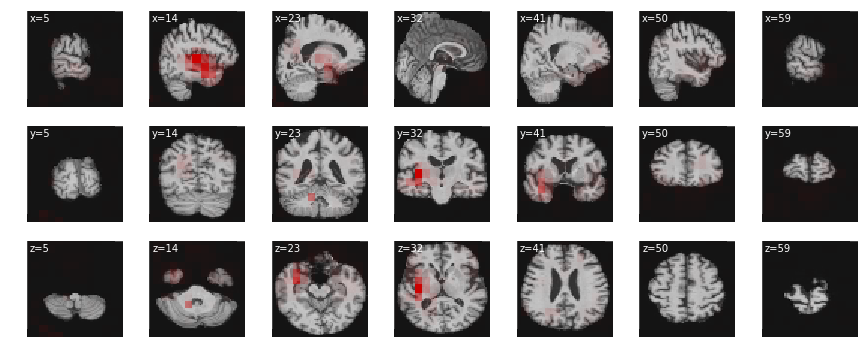

In [28]:
vis_utils.plot_slices(train_ex, overlay=relevance_map_occlusion, 
                      overlay_cmap = vis_utils.alpha_to_red_cmap)

In [30]:
relevance_map_occlusion = interpretation.occlusion(net, train_data[2000], size=10, stride=5, cuda=False, resize=True, verbose=True)

Image was classified as 1 with probability 0.9608314037322998
unoccluded_prob:  0.9608314037322998


output shape:  torch.Size([1, 1])
output:  tensor([[0.9614]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9613584280014038
output shape:  torch.Size([1, 1])
output:  tensor([[0.9628]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.962843120098114
output shape:  torch.Size([1, 1])
output:  tensor([[0.9649]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9649248719215393
output shape:  torch.Size([1, 1])
output:  tensor([[0.9650]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9649776816368103
output shape:  torch.Size([1, 1])
output:  tensor([[0.9650]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9650114178657532
output shape:  torch.Size([1, 1])
output:  tensor([[0.9606]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9606417417526245
output shape:  torch.Size([1, 1])
output:  tensor([[0.9593]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9593327641487122
output shape:  torch.Size([1, 1])
output:  tensor([[0.9609]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9609434604644775
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9563]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9562570452690125
output shape:  torch.Size([1, 1])
output:  tensor([[0.9665]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9664701223373413
output shape:  torch.Size([1, 1])
output:  tensor([[0.9711]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.971118152141571
output shape:  torch.Size([1, 1])
output:  tensor([[0.9585]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9584819078445435
output shape:  torch.Size([1, 1])
output:  tensor([[0.9545]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9544537663459778
output shape:  torch.Size([1, 1])
output:  tensor([[0.9615]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9615350961685181
output shape:  torch.Size([1, 1])
output:  tensor([[0.9625]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.96250981092453
output shape:  torch.Size([1, 1])
output:  tensor([[0.9598]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9597960710525513
output shap

output shape:  torch.Size([1, 1])
output:  tensor([[0.9547]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9546930193901062
output shape:  torch.Size([1, 1])
output:  tensor([[0.9590]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9589651226997375
output shape:  torch.Size([1, 1])
output:  tensor([[0.9601]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9600879549980164
output shape:  torch.Size([1, 1])
output:  tensor([[0.9609]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9608793258666992
output shape:  torch.Size([1, 1])
output:  tensor([[0.9632]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.963230311870575
output shape:  torch.Size([1, 1])
output:  tensor([[0.9629]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9629322290420532
output shape:  torch.Size([1, 1])
output:  tensor([[0.9628]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9627698659896851
output shape:  torch.Size([1, 1])
output:  tensor([[0.9609]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9609439373016357
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9602]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9601618051528931
output shape:  torch.Size([1, 1])
output:  tensor([[0.9613]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9612893462181091
output shape:  torch.Size([1, 1])
output:  tensor([[0.9603]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9603303074836731
output shape:  torch.Size([1, 1])
output:  tensor([[0.9612]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9612182974815369
output shape:  torch.Size([1, 1])
output:  tensor([[0.9605]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9604632258415222
output shape:  torch.Size([1, 1])
output:  tensor([[0.9618]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9617790579795837
output shape:  torch.Size([1, 1])
output:  tensor([[0.9733]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9732988476753235
output shape:  torch.Size([1, 1])
output:  tensor([[0.9647]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9647057056427002
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9639]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9639469981193542
output shape:  torch.Size([1, 1])
output:  tensor([[0.9608]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9608087539672852
output shape:  torch.Size([1, 1])
output:  tensor([[0.9604]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9603946208953857
output shape:  torch.Size([1, 1])
output:  tensor([[0.9596]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9596086144447327
output shape:  torch.Size([1, 1])
output:  tensor([[0.9620]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.962040901184082
output shape:  torch.Size([1, 1])
output:  tensor([[0.9585]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9584680199623108
output shape:  torch.Size([1, 1])
output:  tensor([[0.9593]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9592697620391846
output shape:  torch.Size([1, 1])
output:  tensor([[0.9585]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9584537744522095
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9654]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9654243588447571
output shape:  torch.Size([1, 1])
output:  tensor([[0.9776]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9776426553726196
output shape:  torch.Size([1, 1])
output:  tensor([[0.9741]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.974092960357666
output shape:  torch.Size([1, 1])
output:  tensor([[0.9599]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9598633050918579
output shape:  torch.Size([1, 1])
output:  tensor([[0.9597]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9596828818321228
output shape:  torch.Size([1, 1])
output:  tensor([[0.9589]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9588587284088135
output shape:  torch.Size([1, 1])
output:  tensor([[0.9589]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9588532447814941
output shape:  torch.Size([1, 1])
output:  tensor([[0.9589]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9589104652404785
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9279]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.927941620349884
output shape:  torch.Size([1, 1])
output:  tensor([[0.9629]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9628937244415283
output shape:  torch.Size([1, 1])
output:  tensor([[0.9653]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9653224945068359
output shape:  torch.Size([1, 1])
output:  tensor([[0.9772]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9772366285324097
output shape:  torch.Size([1, 1])
output:  tensor([[0.9710]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9710237383842468
output shape:  torch.Size([1, 1])
output:  tensor([[0.9629]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9629433751106262
output shape:  torch.Size([1, 1])
output:  tensor([[0.9560]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9559659361839294
output shape:  torch.Size([1, 1])
output:  tensor([[0.9559]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9558979868888855
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9639]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9638723731040955
output shape:  torch.Size([1, 1])
output:  tensor([[0.9546]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9546340703964233
output shape:  torch.Size([1, 1])
output:  tensor([[0.9619]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9618808627128601
output shape:  torch.Size([1, 1])
output:  tensor([[0.9654]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9653961658477783
output shape:  torch.Size([1, 1])
output:  tensor([[0.9620]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9619620442390442
output shape:  torch.Size([1, 1])
output:  tensor([[0.9633]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9633138179779053
output shape:  torch.Size([1, 1])
output:  tensor([[0.9569]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9568514823913574
output shape:  torch.Size([1, 1])
output:  tensor([[0.9542]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9541913270950317
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9603]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.960289716720581
output shape:  torch.Size([1, 1])
output:  tensor([[0.9642]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9641882181167603
output shape:  torch.Size([1, 1])
output:  tensor([[0.9632]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9632439017295837
output shape:  torch.Size([1, 1])
output:  tensor([[0.9724]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9723837971687317
output shape:  torch.Size([1, 1])
output:  tensor([[0.9823]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9822916984558105
output shape:  torch.Size([1, 1])
output:  tensor([[0.9932]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9931704998016357
output shape:  torch.Size([1, 1])
output:  tensor([[0.9843]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9843215942382812
output shape:  torch.Size([1, 1])
output:  tensor([[0.8778]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.8778209686279297
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9581]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9580821394920349
output shape:  torch.Size([1, 1])
output:  tensor([[0.9557]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9556820392608643
output shape:  torch.Size([1, 1])
output:  tensor([[0.9552]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9551634192466736
output shape:  torch.Size([1, 1])
output:  tensor([[0.9702]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9701724648475647
output shape:  torch.Size([1, 1])
output:  tensor([[0.9729]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9729205965995789
output shape:  torch.Size([1, 1])
output:  tensor([[0.9686]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9686256647109985
output shape:  torch.Size([1, 1])
output:  tensor([[0.9664]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9663768410682678
output shape:  torch.Size([1, 1])
output:  tensor([[0.9605]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9604800343513489
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9634]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9634028673171997
output shape:  torch.Size([1, 1])
output:  tensor([[0.9719]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9719399809837341
output shape:  torch.Size([1, 1])
output:  tensor([[0.9695]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9694725871086121
output shape:  torch.Size([1, 1])
output:  tensor([[0.9556]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9556164145469666
output shape:  torch.Size([1, 1])
output:  tensor([[0.9600]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9599747657775879
output shape:  torch.Size([1, 1])
output:  tensor([[0.9619]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9618794918060303
output shape:  torch.Size([1, 1])
output:  tensor([[0.9608]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9607893824577332
output shape:  torch.Size([1, 1])
output:  tensor([[0.9621]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9621206521987915
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9516]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9515966176986694
output shape:  torch.Size([1, 1])
output:  tensor([[0.9680]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9679803848266602
output shape:  torch.Size([1, 1])
output:  tensor([[0.9623]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9623406529426575
output shape:  torch.Size([1, 1])
output:  tensor([[0.9580]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9580080509185791
output shape:  torch.Size([1, 1])
output:  tensor([[0.9584]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9584258794784546
output shape:  torch.Size([1, 1])
output:  tensor([[0.9511]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9511159658432007
output shape:  torch.Size([1, 1])
output:  tensor([[0.9573]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9572767019271851
output shape:  torch.Size([1, 1])
output:  tensor([[0.9602]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9602358341217041
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9506]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.950616180896759
output shape:  torch.Size([1, 1])
output:  tensor([[0.9470]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9470382332801819
output shape:  torch.Size([1, 1])
output:  tensor([[0.9564]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9563665986061096
output shape:  torch.Size([1, 1])
output:  tensor([[0.9630]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9630283713340759
output shape:  torch.Size([1, 1])
output:  tensor([[0.9605]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9604992866516113
output shape:  torch.Size([1, 1])
output:  tensor([[0.9491]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9490891695022583
output shape:  torch.Size([1, 1])
output:  tensor([[0.9465]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9464781880378723
output shape:  torch.Size([1, 1])
output:  tensor([[0.9508]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9508274793624878
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9614]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9613611698150635
output shape:  torch.Size([1, 1])
output:  tensor([[0.9626]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9626151919364929
output shape:  torch.Size([1, 1])
output:  tensor([[0.9646]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9646328091621399
output shape:  torch.Size([1, 1])
output:  tensor([[0.9928]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9927664995193481
output shape:  torch.Size([1, 1])
output:  tensor([[0.9883]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9883129000663757
output shape:  torch.Size([1, 1])
output:  tensor([[0.9294]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9293721914291382
output shape:  torch.Size([1, 1])
output:  tensor([[0.9530]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9530302882194519
output shape:  torch.Size([1, 1])
output:  tensor([[0.9497]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9496669173240662
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9581]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9581364393234253
output shape:  torch.Size([1, 1])
output:  tensor([[0.9576]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9576480388641357
output shape:  torch.Size([1, 1])
output:  tensor([[0.9526]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9526488184928894
output shape:  torch.Size([1, 1])
output:  tensor([[0.9467]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9467414021492004
output shape:  torch.Size([1, 1])
output:  tensor([[0.9505]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.950459361076355
output shape:  torch.Size([1, 1])
output:  tensor([[0.9488]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9487740993499756
output shape:  torch.Size([1, 1])
output:  tensor([[0.9594]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9594242572784424
output shape:  torch.Size([1, 1])
output:  tensor([[0.9550]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9549577832221985
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9693]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9693363904953003
output shape:  torch.Size([1, 1])
output:  tensor([[0.9509]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9508984088897705
output shape:  torch.Size([1, 1])
output:  tensor([[0.9584]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9583548903465271
output shape:  torch.Size([1, 1])
output:  tensor([[0.9602]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9601860642433167
output shape:  torch.Size([1, 1])
output:  tensor([[0.9613]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9612741470336914
output shape:  torch.Size([1, 1])
output:  tensor([[0.9604]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9604170322418213
output shape:  torch.Size([1, 1])
output:  tensor([[0.9601]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.96009761095047
output shape:  torch.Size([1, 1])
output:  tensor([[0.9608]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9607505202293396
output sha

output shape:  torch.Size([1, 1])
output:  tensor([[0.9559]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9558836221694946
output shape:  torch.Size([1, 1])
output:  tensor([[0.9496]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.949550449848175
output shape:  torch.Size([1, 1])
output:  tensor([[0.9519]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9518850445747375
output shape:  torch.Size([1, 1])
output:  tensor([[0.9526]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9526115655899048
output shape:  torch.Size([1, 1])
output:  tensor([[0.9544]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9544464349746704
output shape:  torch.Size([1, 1])
output:  tensor([[0.9588]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9588204622268677
output shape:  torch.Size([1, 1])
output:  tensor([[0.9691]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9691187143325806
output shape:  torch.Size([1, 1])
output:  tensor([[0.9532]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9532375931739807
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9644]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9644235372543335
output shape:  torch.Size([1, 1])
output:  tensor([[0.9615]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9614825248718262
output shape:  torch.Size([1, 1])
output:  tensor([[0.9590]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9590364098548889
output shape:  torch.Size([1, 1])
output:  tensor([[0.9506]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9505877494812012
output shape:  torch.Size([1, 1])
output:  tensor([[0.9449]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9448872804641724
output shape:  torch.Size([1, 1])
output:  tensor([[0.9441]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9441235661506653
output shape:  torch.Size([1, 1])
output:  tensor([[0.9538]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9538466334342957
output shape:  torch.Size([1, 1])
output:  tensor([[0.9576]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9576334953308105
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9719]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9718688130378723
output shape:  torch.Size([1, 1])
output:  tensor([[0.9792]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9792100787162781
output shape:  torch.Size([1, 1])
output:  tensor([[0.9862]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9861617088317871
output shape:  torch.Size([1, 1])
output:  tensor([[0.9747]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9747194647789001
output shape:  torch.Size([1, 1])
output:  tensor([[0.9504]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9503825902938843
output shape:  torch.Size([1, 1])
output:  tensor([[0.9687]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9686753153800964
output shape:  torch.Size([1, 1])
output:  tensor([[0.9591]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9590822458267212
output shape:  torch.Size([1, 1])
output:  tensor([[0.9512]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9512379765510559
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9635]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9634718298912048
output shape:  torch.Size([1, 1])
output:  tensor([[0.9595]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9594525694847107
output shape:  torch.Size([1, 1])
output:  tensor([[0.9575]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9575494527816772
output shape:  torch.Size([1, 1])
output:  tensor([[0.9576]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9575921893119812
output shape:  torch.Size([1, 1])
output:  tensor([[0.9611]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9610535502433777
output shape:  torch.Size([1, 1])
output:  tensor([[0.9612]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9612435102462769
output shape:  torch.Size([1, 1])
output:  tensor([[0.9648]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9648359417915344
output shape:  torch.Size([1, 1])
output:  tensor([[0.9641]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9641348719596863
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9597]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9596558213233948
output shape:  torch.Size([1, 1])
output:  tensor([[0.9598]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9597505927085876
output shape:  torch.Size([1, 1])
output:  tensor([[0.9600]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9599677324295044
output shape:  torch.Size([1, 1])
output:  tensor([[0.9622]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9622082114219666
output shape:  torch.Size([1, 1])
output:  tensor([[0.9599]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9599112868309021
output shape:  torch.Size([1, 1])
output:  tensor([[0.9587]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9586851000785828
output shape:  torch.Size([1, 1])
output:  tensor([[0.9601]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9601070284843445
output shape:  torch.Size([1, 1])
output:  tensor([[0.9721]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9720835089683533
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9563]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9563412070274353
output shape:  torch.Size([1, 1])
output:  tensor([[0.9612]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9611842632293701
output shape:  torch.Size([1, 1])
output:  tensor([[0.9616]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9616471529006958
output shape:  torch.Size([1, 1])
output:  tensor([[0.9632]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9631933569908142
output shape:  torch.Size([1, 1])
output:  tensor([[0.9585]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9584901332855225
output shape:  torch.Size([1, 1])
output:  tensor([[0.9505]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9504889845848083
output shape:  torch.Size([1, 1])
output:  tensor([[0.9644]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.964423656463623
output shape:  torch.Size([1, 1])
output:  tensor([[0.9627]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9627307653427124
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9627]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9627227783203125
output shape:  torch.Size([1, 1])
output:  tensor([[0.9503]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9502633213996887
output shape:  torch.Size([1, 1])
output:  tensor([[0.9490]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9489995837211609
output shape:  torch.Size([1, 1])
output:  tensor([[0.9511]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9511276483535767
output shape:  torch.Size([1, 1])
output:  tensor([[0.9556]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9556281566619873
output shape:  torch.Size([1, 1])
output:  tensor([[0.9632]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9632354974746704
output shape:  torch.Size([1, 1])
output:  tensor([[0.9664]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9664429426193237
output shape:  torch.Size([1, 1])
output:  tensor([[0.9685]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.968535304069519
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9633]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9632852673530579
output shape:  torch.Size([1, 1])
output:  tensor([[0.9650]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9649876952171326
output shape:  torch.Size([1, 1])
output:  tensor([[0.9638]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.963844895362854
output shape:  torch.Size([1, 1])
output:  tensor([[0.9607]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9606919884681702
output shape:  torch.Size([1, 1])
output:  tensor([[0.9653]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9653028249740601
output shape:  torch.Size([1, 1])
output:  tensor([[0.9653]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9653003811836243
output shape:  torch.Size([1, 1])
output:  tensor([[0.9657]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9657377004623413
output shape:  torch.Size([1, 1])
output:  tensor([[0.9695]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.969465434551239
output sha

output shape:  torch.Size([1, 1])
output:  tensor([[0.9700]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9699695706367493
output shape:  torch.Size([1, 1])
output:  tensor([[0.9674]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9673900604248047
output shape:  torch.Size([1, 1])
output:  tensor([[0.9613]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9613471031188965
output shape:  torch.Size([1, 1])
output:  tensor([[0.9689]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9688596725463867
output shape:  torch.Size([1, 1])
output:  tensor([[0.9646]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9646013975143433
output shape:  torch.Size([1, 1])
output:  tensor([[0.9685]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9685444235801697
output shape:  torch.Size([1, 1])
output:  tensor([[0.9598]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9597689509391785
output shape:  torch.Size([1, 1])
output:  tensor([[0.9612]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.961199939250946
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9631]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9631333351135254
output shape:  torch.Size([1, 1])
output:  tensor([[0.9626]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9626498818397522
output shape:  torch.Size([1, 1])
output:  tensor([[0.9641]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9640609622001648
output shape:  torch.Size([1, 1])
output:  tensor([[0.9619]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9618924260139465
output shape:  torch.Size([1, 1])
output:  tensor([[0.9633]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.963326096534729
output shape:  torch.Size([1, 1])
output:  tensor([[0.9651]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9651340246200562
output shape:  torch.Size([1, 1])
output:  tensor([[0.9704]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9704115390777588
output shape:  torch.Size([1, 1])
output:  tensor([[0.9698]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9697765707969666
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9644]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9644010066986084
output shape:  torch.Size([1, 1])
output:  tensor([[0.9641]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9640543460845947
output shape:  torch.Size([1, 1])
output:  tensor([[0.9552]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9552454352378845
output shape:  torch.Size([1, 1])
output:  tensor([[0.9453]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9452946186065674
output shape:  torch.Size([1, 1])
output:  tensor([[0.9586]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9585719704627991
output shape:  torch.Size([1, 1])
output:  tensor([[0.9652]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9651817679405212
output shape:  torch.Size([1, 1])
output:  tensor([[0.9601]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9600536823272705
output shape:  torch.Size([1, 1])
output:  tensor([[0.9667]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9666740298271179
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9524]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9524414539337158
output shape:  torch.Size([1, 1])
output:  tensor([[0.9519]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9519040584564209
output shape:  torch.Size([1, 1])
output:  tensor([[0.9551]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9551493525505066
output shape:  torch.Size([1, 1])
output:  tensor([[0.9628]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9627718329429626
output shape:  torch.Size([1, 1])
output:  tensor([[0.9639]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9639138579368591
output shape:  torch.Size([1, 1])
output:  tensor([[0.9633]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9633371829986572
output shape:  torch.Size([1, 1])
output:  tensor([[0.9600]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9599854350090027
output shape:  torch.Size([1, 1])
output:  tensor([[0.9555]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9554595351219177
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9580]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9579946994781494
output shape:  torch.Size([1, 1])
output:  tensor([[0.9596]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9595637321472168
output shape:  torch.Size([1, 1])
output:  tensor([[0.9539]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9539203643798828
output shape:  torch.Size([1, 1])
output:  tensor([[0.9615]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9615383744239807
output shape:  torch.Size([1, 1])
output:  tensor([[0.9674]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9674282670021057
output shape:  torch.Size([1, 1])
output:  tensor([[0.9636]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.963580846786499
output shape:  torch.Size([1, 1])
output:  tensor([[0.9620]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9620010852813721
output shape:  torch.Size([1, 1])
output:  tensor([[0.9590]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9589845538139343
output sh

output shape:  torch.Size([1, 1])
output:  tensor([[0.9556]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.955585777759552
output shape:  torch.Size([1, 1])
output:  tensor([[0.9548]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.954788327217102
output shape:  torch.Size([1, 1])
output:  tensor([[0.9613]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9613454341888428
output shape:  torch.Size([1, 1])
output:  tensor([[0.9634]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9633545279502869
output shape:  torch.Size([1, 1])
output:  tensor([[0.9612]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.961237370967865
output shape:  torch.Size([1, 1])
output:  tensor([[0.9626]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9626431465148926
output shape:  torch.Size([1, 1])
output:  tensor([[0.9522]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.952168345451355
output shape:  torch.Size([1, 1])
output:  tensor([[0.9470]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9469842314720154
output shape

output shape:  torch.Size([1, 1])
output:  tensor([[0.9622]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9622121453285217
output shape:  torch.Size([1, 1])
output:  tensor([[0.9615]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9614624381065369
output shape:  torch.Size([1, 1])
output:  tensor([[0.9622]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.962213933467865
output shape:  torch.Size([1, 1])
output:  tensor([[0.9593]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9593304395675659
output shape:  torch.Size([1, 1])
output:  tensor([[0.9621]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.962124764919281
output shape:  torch.Size([1, 1])
output:  tensor([[0.9595]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9594672918319702
output shape:  torch.Size([1, 1])
output:  tensor([[0.9567]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9567171335220337
output shape:  torch.Size([1, 1])
output:  tensor([[0.9631]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9630758166313171
output sha

output shape:  torch.Size([1, 1])
output:  tensor([[0.9585]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9584518074989319
output shape:  torch.Size([1, 1])
output:  tensor([[0.9561]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9561407566070557
output shape:  torch.Size([1, 1])
output:  tensor([[0.9616]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9615952372550964
output shape:  torch.Size([1, 1])
output:  tensor([[0.9672]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9671506285667419
output shape:  torch.Size([1, 1])
output:  tensor([[0.9669]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9668917655944824
output shape:  torch.Size([1, 1])
output:  tensor([[0.9684]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9684402346611023
output shape:  torch.Size([1, 1])
output:  tensor([[0.9601]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9600648880004883
output shape:  torch.Size([1, 1])
output:  tensor([[0.9621]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9620915651321411
output s

output shape:  torch.Size([1, 1])
output:  tensor([[0.9610]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9609878659248352
output shape:  torch.Size([1, 1])
output:  tensor([[0.9606]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9605885148048401
output shape:  torch.Size([1, 1])
output:  tensor([[0.9596]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9596019387245178
output shape:  torch.Size([1, 1])
output:  tensor([[0.9635]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9634600877761841
output shape:  torch.Size([1, 1])
output:  tensor([[0.9646]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9645738005638123
output shape:  torch.Size([1, 1])
output:  tensor([[0.9600]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9600301384925842
output shape:  torch.Size([1, 1])
output:  tensor([[0.9607]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9607083201408386
output shape:  torch.Size([1, 1])
output:  tensor([[0.9611]], grad_fn=<SigmoidBackward>)
occluded_prob:  0.9610530138015747
output s

-1.2525044640745717 2.4545196225244514 0.0 0.10233479738235474


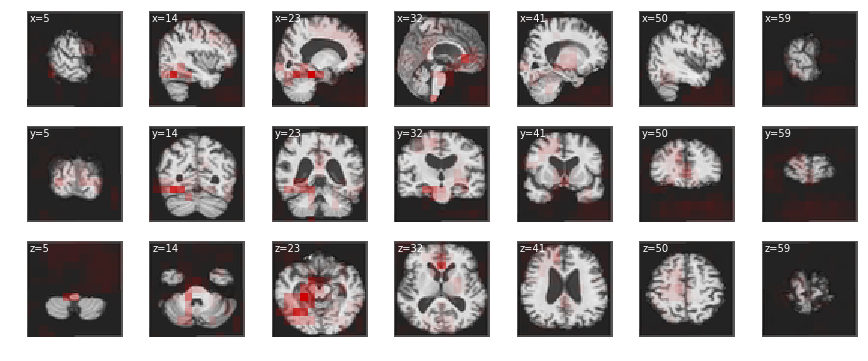

In [31]:
vis_utils.plot_slices(train_data[2000][0], overlay=relevance_map_occlusion, 
                      overlay_cmap = vis_utils.alpha_to_red_cmap)

(-0.5, 63.5, 63.5, -0.5)

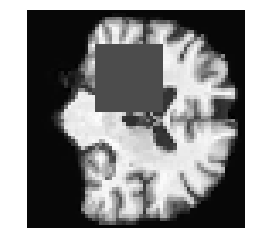

In [29]:
# Plot occlusion patch on image.
occluded_image = train_data[0][0][:, 30, :].copy()
size = 20
occluded_image[10:10+size, 20:20+size] = 0
plt.imshow(occluded_image, cmap='gray')
plt.axis('off')